In [1]:
%matplotlib inline
import sys 
import xarray as xr
import numpy as np
import os 
import warnings
import yaml
from random import randint
import math
from datetime import datetime, timedelta
import netCDF4 as nc
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean
cm = cmocean.cm.dense

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    
    Parameters:
        lat1, lon1: Latitude and longitude of point 1 in decimal degrees.
        lat2, lon2: Latitude and longitude of point 2 in decimal degrees.
    
    Returns:
        Distance in kilometers.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371000 # Radius of Earth in kilometers
    return r * c

In [3]:
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [4]:
path_runs = '/home/jvalenti/MOAD/results/Graham/MFpaper/' 
path_cons = '/home/jvalenti/MOAD/results/Graham/' 
config = ['/home/jvalenti/scratch/OParcels_runs/Parcels_outfall/outfall_runs.yaml']
restart = 0
paths = path(0)

path_NEMO = make_prefix(datetime(2019, 1, 1),paths['NEMO'])

In [5]:
coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')

In [6]:
def finder2(target_lat, target_lon,mask=mask):
# Load grid data (e.g., from a NetCDF file)
    lat = mask.nav_lat
    lon = mask.nav_lon

    #find closest grid
    distance = ((lat - target_lat)**2 + (lon - target_lon)**2)**0.5
    nearest_index = distance.argmin()
    return int(nearest_index // lon.shape[1]), int(nearest_index % lon.shape[1])

In [7]:
sys.path.append('/home/jvalenti/MOAD/tools')

from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools)

In [8]:
def artificial_hr(var,Ni,mask):    
    new_conc = np.zeros_like(mask.tmask[0,...],dtype='f')
    for i in range(new_conc.shape[1]):
        for j in range(new_conc.shape[2]):
            new_conc[:,i,j]=var[:,int(i/Ni),int(j/Ni)]
    return new_conc

In [9]:
fmesh = nc.Dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')
fbathy=nc.Dataset('/home/jvalenti/MOAD/grid/bathymetry_201702.nc')

bathy = fbathy.variables['Bathymetry'][:,:]
thalweg_fix = np.loadtxt('mythalweg5.txt', delimiter=' ', dtype=int)
thalweg_original = np.loadtxt("/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt", delimiter=' ', dtype=int)

In [10]:
thalweg_coord = []
for th in thalweg_fix:
    thalweg_coord.append([float(mask.nav_lon[th[0],th[1]].values),float(mask.nav_lat[th[0],th[1]].values)])

thalweg_original_coord = []
for th in thalweg_original:
    thalweg_original_coord.append([float(mask.nav_lon[th[0],th[1]].values),float(mask.nav_lat[th[0],th[1]].values)])
thalweg_coord =np.array(thalweg_coord)
thalweg_original_coord = np.array(thalweg_original_coord)

In [11]:
conc = np.load(path_cons+'Run_Enero20190101_.npy')
conc2 = np.load(path_cons+'Run_Febrero20190201_.npy')
conc3 = np.load(path_cons+'Run_Marzo20190301_.npy')
conc4 = np.load(path_cons+'Run_Abril20190401_.npy')

conc_winter = (conc + conc2 + conc3+ conc4)/4

conc = np.load(path_cons+'Run_Junio20190601_.npy')
conc2 = np.load(path_cons+'Run_Julio20190701_.npy')
conc3 = np.load(path_cons+'Run_Agosto20190801_.npy')
conc_summer = (conc + conc2 + conc3)/3

conc_average = (conc_summer+conc_winter)/2

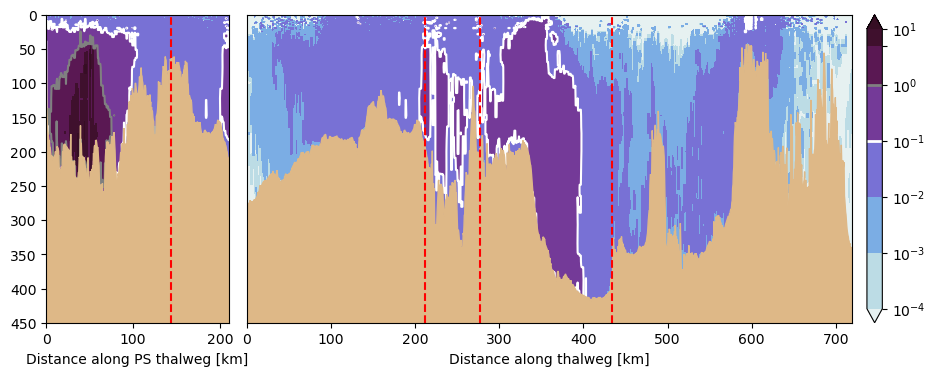

In [12]:
from salishsea_tools import visualisations as vis

fig,ax=plt.subplots(1,2,figsize=(12,4),width_ratios=[0.25, 1])

fmesh = nc.Dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')
fbathy=nc.Dataset('/home/jvalenti/MOAD/grid/bathymetry_201702.nc')

clevels = [1e-4,1e-3,1e-2,1e-1,1,5,10]
thalweg_file = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_file2 = 'mythalweg6.txt'
var = artificial_hr(conc_average,3,mask)+1e-15
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)
thalweg_pts2 = np.loadtxt(thalweg_file2, delimiter=' ', dtype=int)
depth = fmesh.variables['gdept_0'][:]

dep_thal, distance, var_thal = vis.load_thalweg(depth[0, ...], var, fbathy['nav_lon'][:], fbathy['nav_lat'][:],thalweg_pts)
xx_thal = distance
ax[1].set_xlabel('Distance along thalweg [km]')
var_plot = vis._fill_in_bathy(var_thal, fmesh, thalweg_pts)
im = ax[1].contourf(xx_thal, dep_thal, var_plot, clevels, cmap=cmocean.cm.dense,extend='both',norm=colors.LogNorm())
ax[1].contour(xx_thal, dep_thal, var_plot, levels=[0.1,2],colors=['White','grey'],zorder=1)

cbar = plt.colorbar(im, ax=ax[1],pad=0.02)

vis._add_bathy_patch(xx_thal, fbathy['Bathymetry'][:], thalweg_pts, ax[1], color='burlywood')
ax[1].tick_params(left = False, right = False , labelleft = False) 

dep_thal, distance, var_thal = vis.load_thalweg(depth[0, ...], var, fbathy['nav_lon'][:], fbathy['nav_lat'][:],thalweg_pts2)
xx_thal = distance
ax[0].set_xlabel('Distance along PS thalweg [km]')
var_plot = vis._fill_in_bathy(var_thal, fmesh, thalweg_pts2)
im = ax[0].contourf(xx_thal, dep_thal, var_plot, clevels, cmap=cmocean.cm.dense,extend='both',norm=colors.LogNorm())
ax[0].contour(xx_thal, dep_thal, var_plot, levels=[0.1,1],colors=['White','grey'],zorder=1)

vis._add_bathy_patch(xx_thal, fbathy['Bathymetry'][:], thalweg_pts2, ax[0], color='burlywood')

fig.subplots_adjust(wspace=0.04, hspace=0.1)
ax[1].set_ylim([450,0])
ax[1].axvline(x=212,c='red',linestyle='--')
ax[1].axvline(x=277.5,c='red',linestyle='--')
ax[1].axvline(x=434.5,c='red',linestyle='--')
ax[0].axvline(x=144,c='red',linestyle='--')

#ax[1].scatter(185,445,c='red',marker='^')
#ax[0].scatter(180,445,c='blue',marker='^')
#ax[1].axvline(x=185,c='k')
ax[0].set_ylim([450,0])
#ax[0].axvline(x=180,c='k')
ax[0].set_xlim([0,210])
#fig.savefig('thalweg.pdf')
levels = [0.1,1]
for level, color in zip(levels, ['white', 'grey']):
    cbar.ax.axhline(y=level, color=color, linewidth=2)

In [13]:
import pandas as pd

months = {'Feb':['Run_Febrero20190201_.nc',1],'Mar':['Run_Marzo20190301_.nc',1],'Abr':['Run_Abril20190401_.nc',1],'Jun':['Run_Junio20190601_.nc',1],'Jul':['Run_Julio20190701_.nc',1],'Aug':['Run_Agosto20190801_.nc',1]}

ds = xr.open_dataset(path_runs+'Run_Enero20190101_.nc', decode_times=False)
DS3 = ds.to_dataframe()
DS3 = DS3.dropna()
DS3 = DS3[DS3.time>0]
DS2 = DS3[DS3.status==2]
DS3 = DS3[DS3.status==3]
unique_DS3 = DS3.lon.unique()
DS3 = DS3[DS3.lon.isin(unique_DS3)]
unique_DS2 = DS2.lon.unique()
DS2 = DS2[DS2.lon.isin(unique_DS2)]

for month in months:
    ds = xr.open_dataset(path_runs+months[month][0], decode_times=False)
    DSN = ds.to_dataframe()
    DSN = DSN.dropna()
    DSN = DSN[DSN.time>0]
    DSN2 = DSN[DSN.status==2]
    DSN = DSN[DSN.status==3]
    unique_DS3 = DSN.lon.unique()
    DSN = DSN[DSN.lon.isin(unique_DS3)]
    unique_DS2 = DSN2.lon.unique()
    DSN2 = DSN2[DSN2.lon.isin(unique_DS2)]
    DS3= pd.concat([DS3, DSN])
    DS2= pd.concat([DS2, DSN2])

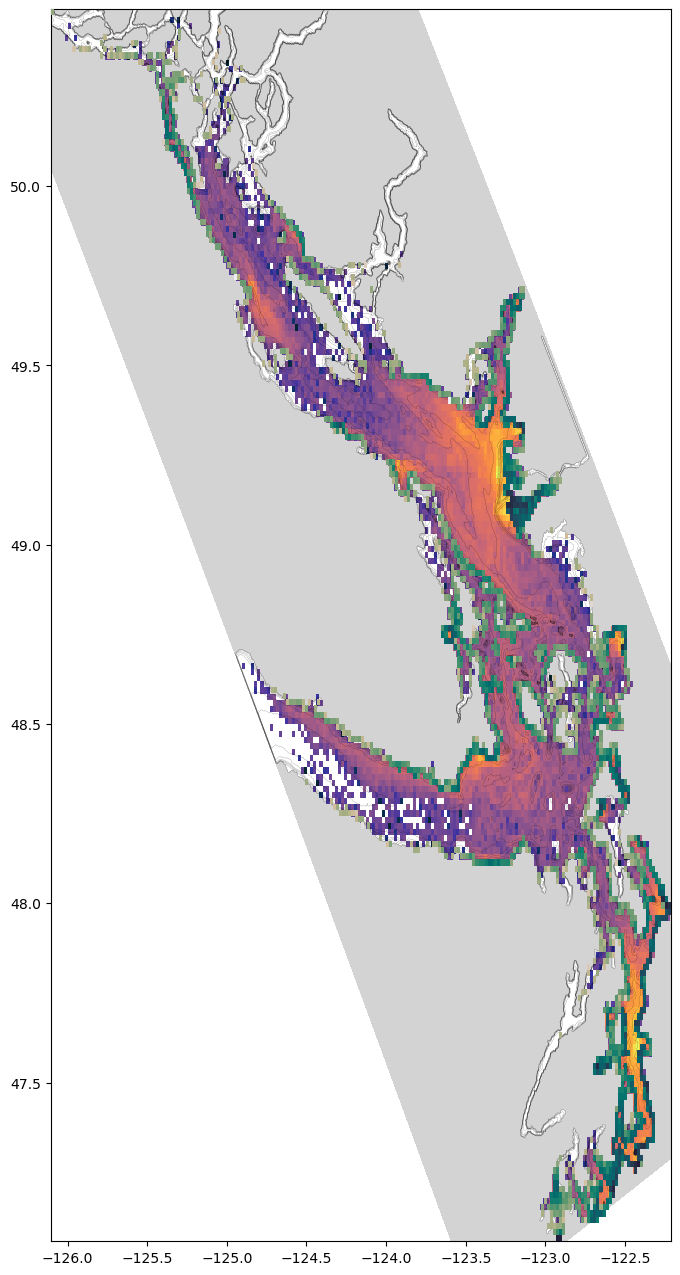

In [14]:
N = 200
fig,axes=plt.subplots(1,1,figsize=(8,16))

LON3 = DS3.lon
LAT3 = DS3.lat

LON2 = DS2.lon
LAT2 = DS2.lat

h0, xedges, yedges, image0 = axes.hist2d(LON3,LAT3,N,norm=colors.LogNorm())
h2, xedges2, yedges2, image0 = axes.hist2d(LON2,LAT2,N,norm=colors.LogNorm())
axes.clear()
xlen = haversine(yedges[0], xedges[0], yedges[0], xedges[1])
ylen = haversine(yedges[0], xedges[0], yedges[1], xedges[0]) 

sarea = xlen*ylen

xlen2 = haversine(yedges2[0], xedges2[0], yedges2[0], xedges2[1])
ylen2 = haversine(yedges2[0], xedges2[0], yedges2[1], xedges2[0]) 
lengthx = np.sqrt(xlen2**2 + ylen2**2)

axes.clear()
axes.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
axes.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
#axes.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

h0, xedges, yedges, image0 = axes.hist2d(LON3,LAT3,[xedges, yedges],weights=(LON3/LON3)*5e6/(sarea*204),cmap =cmocean.cm.thermal,norm=colors.LogNorm()) #27.75 days of output
h2, xedges2, yedges2, image2 = axes.hist2d(LON2,LAT2,[xedges2, yedges2],weights=(LON2/LON2)*5e6/(lengthx*204),cmap=cmocean.cm.rain,norm=colors.LogNorm(),zorder=3)

# plt.plot(Xline[65:75],yline0[65:75],'r--')
# plt.plot(Xline[:50],yline1[:50],'r--')
# plt.plot(Xline[30:],yline2[30:],'r--')
# plt.plot(Xline[30:],yline3[30:],'r--')

In [19]:
Xedges,Yedges = np.meshgrid(xedges,yedges)
ii_sed = np.zeros_like(Xedges)
jj_sed = np.zeros_like(Xedges)
for i in range(N):
    for j in range(N):
        jjj,iii = finder2(Yedges[i,j],Xedges[i,j])
        ii_sed[i,j]=iii
        jj_sed[i,j]=jjj

Xedges2,Yedges2 = np.meshgrid(xedges2,yedges2)
ii_sed2 = np.zeros_like(Xedges2)
jj_sed2 = np.zeros_like(Xedges2)
for i in range(N):
    for j in range(N):
        jjj,iii = finder2(Yedges2[i,j],Xedges2[i,j])
        ii_sed2[i,j]=iii
        jj_sed2[i,j]=jjj

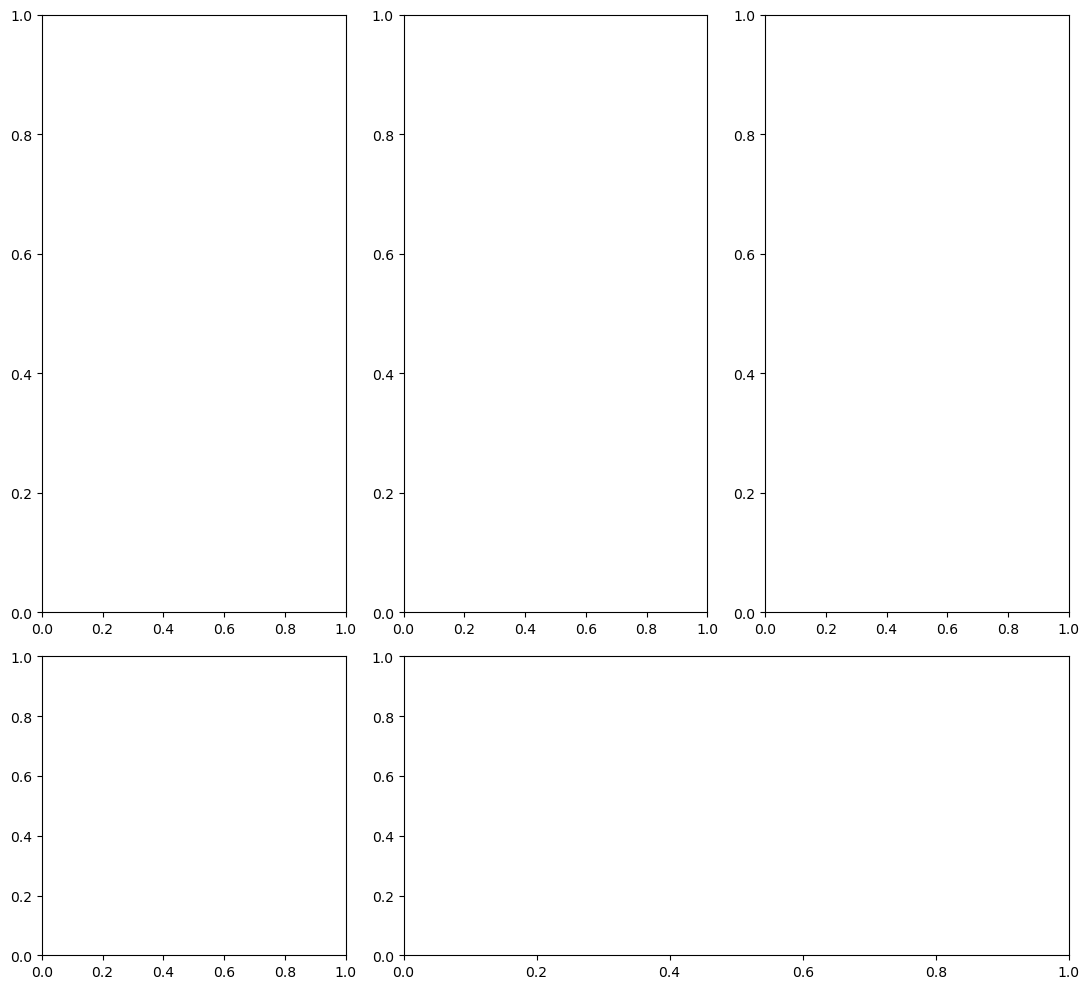

In [20]:
import matplotlib.gridspec as gridspec

# Create a figure and a GridSpec layout
fig = plt.figure(figsize=(11, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[2,1],width_ratios=[1,1,1])

ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[0, 1]) 
ax5 = fig.add_subplot(gs[0, 2]) 

ax3 = fig.add_subplot(gs[1, 0]) 
ax4 = fig.add_subplot(gs[1, 1:]) 

plt.tight_layout()
axes = fig.get_axes()

In [21]:
x = np.linspace(0,397,398)
y = np.linspace(0,897,898)
X, Y =np.meshgrid(x,y)

ii_sed2[np.isnan(ii_sed2)]=0
ii_sed[np.isnan(ii_sed)]=0
axes[0].contourf(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='#B1CBA6')
#axes[0].contour(X,Y, mask.totaldepth,colors='k',linewidths=0.1,levels=np.linspace(50,450,6))
#imageSSC = axes[1].contourf(ii_sed[:-1,:-1],jj_sed[:-1,:-1], h0.T,norm=colors.LogNorm(),levels=np.logspace(-2,2,100),cmap = cmocean.cm.thermal,extend='min',vmin=1e-2)
imageSSC = axes[1].pcolormesh(ii_sed[:-1,:-1],jj_sed[:-1,:-1],h0.T,cmap=cmocean.cm.thermal,norm=colors.LogNorm(vmin=1e-2,vmax=1e3),snap = True)
imageSSC2 = axes[0].pcolormesh(ii_sed2[:-1,:-1],jj_sed[:-1,:-1],h2.T,cmap=cmocean.cm.turbid,norm=colors.LogNorm(vmin=1,vmax=1e4),snap = True)
#imageSSC2 = axes[0].contourf(ii_sed2[:-1,:-1],jj_sed2[:-1,:-1], h2.T,norm=colors.LogNorm(),levels=np.logspace(0,4,100),cmap = cmocean.cm.turbid,extend='max',vmax=1e4)
axes[1].contourf(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='#B1CBA6')
axes[0].plot(thalweg_fix[:,1]+1,thalweg_fix[:,0]+1,marker='o',color='c',markersize=0.25)
axes[0].plot(thalweg_original[:,1]+1,thalweg_original[:,0]+1,marker='o',color='b',markersize=0.25)
axes[0].set_ylim(0,850)
axes[1].set_ylim(0,850)
f = 1.14
axes[1].set_aspect(f)
axes[0].set_aspect(f)
axes[2].set_aspect(f)

cbar1 =plt.colorbar(imageSSC,ax=axes[1],pad=0.05,orientation='vertical',extend='both')
cbar1.set_label(r"[MFm$^{-2}$d$^{-1}$]", fontsize=10)
cbar1.ax.yaxis.set_label_coords(0.15, 0.5)
#cbar1.ax.xaxis.set_label_coords(0.5, 0.8)
#cbar1.ax.set_position([0.6, 0.28, 0.07, 0.6]) 

cbar2 =plt.colorbar(imageSSC2,ax=axes[0],pad=0.05,orientation='vertical',extend='max')
cbar2.set_label(r"[MFm$^{-1}$d$^{-1}$]", fontsize=10)
#cbar2.ax.xaxis.set_label_coords(0.5, 0.8)
cbar2.ax.yaxis.set_label_coords(0.15, 0.5)
axes[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[0].tick_params(axis='y', which='both', left=False,  labelleft=False)
axes[1].tick_params(axis='y', which='both', left=False,  labelleft=False)
axes[2].tick_params(axis='y', which='both', left=False,  labelleft=False)
fig.subplots_adjust(wspace=0.2, hspace=0.05)
cbar1.set_ticks(np.logspace(-2,3,6)) 
cbar2.set_ticks(np.logspace(0,4,5)) 


imageSSC3 = axes[2].pcolormesh(X,Y,np.sum(var[0:5,:,:],axis=0)/5,cmap=cmocean.cm.dense,norm=colors.LogNorm(vmin=1e-4,vmax=10),snap = True)
axes[2].contour(X,Y,np.sum(var[0:5,:,:],axis=0)/5, levels=[0.1,2],colors=['yellow', 'orange'],zorder=1,linewidth=0.2)
axes[2].contourf(X,Y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='#B1CBA6')

cbar4 =plt.colorbar(imageSSC3,ax=axes[2],pad=0.05,orientation='vertical',extend='both')
levels = [1e-1,1]
for level, color in zip(levels, ['yellow', 'orange']):
    cbar4.ax.axhline(y=level, color=color, linewidth=2)
cbar4.set_label(r"[MFm$^{-3}$]", fontsize=10)
cbar4.ax.yaxis.set_label_coords(0.15, 0.5)

imageSSC2.cmap.set_over('red')
imageSSC3.cmap.set_over('black')
imageSSC.cmap.set_under('black')


/tmp/ipykernel_2852499/1990455274.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  imageSSC = axes[1].pcolormesh(ii_sed[:-1,:-1],jj_sed[:-1,:-1],h0.T,cmap=cmocean.cm.thermal,norm=colors.LogNorm(vmin=1e-2,vmax=1e3),snap = True)
/tmp/ipykernel_2852499/1990455274.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  imageSSC2 = axes[0].pcolormesh(ii_sed2[:-1,:-1],jj_sed[:-1,:-1],h2.T,cmap=cmocean.cm.turbid,norm=colors.LogNorm(vmin=1,vmax=1e4),snap = True)
/tmp/ipykernel_2852499/1990455274.py:23: UserWarning: Adding colorbar to a different Figure <Figure size 1100x1000 with 6 Axes> 

<Figure size 640x480 with 0 Axes>

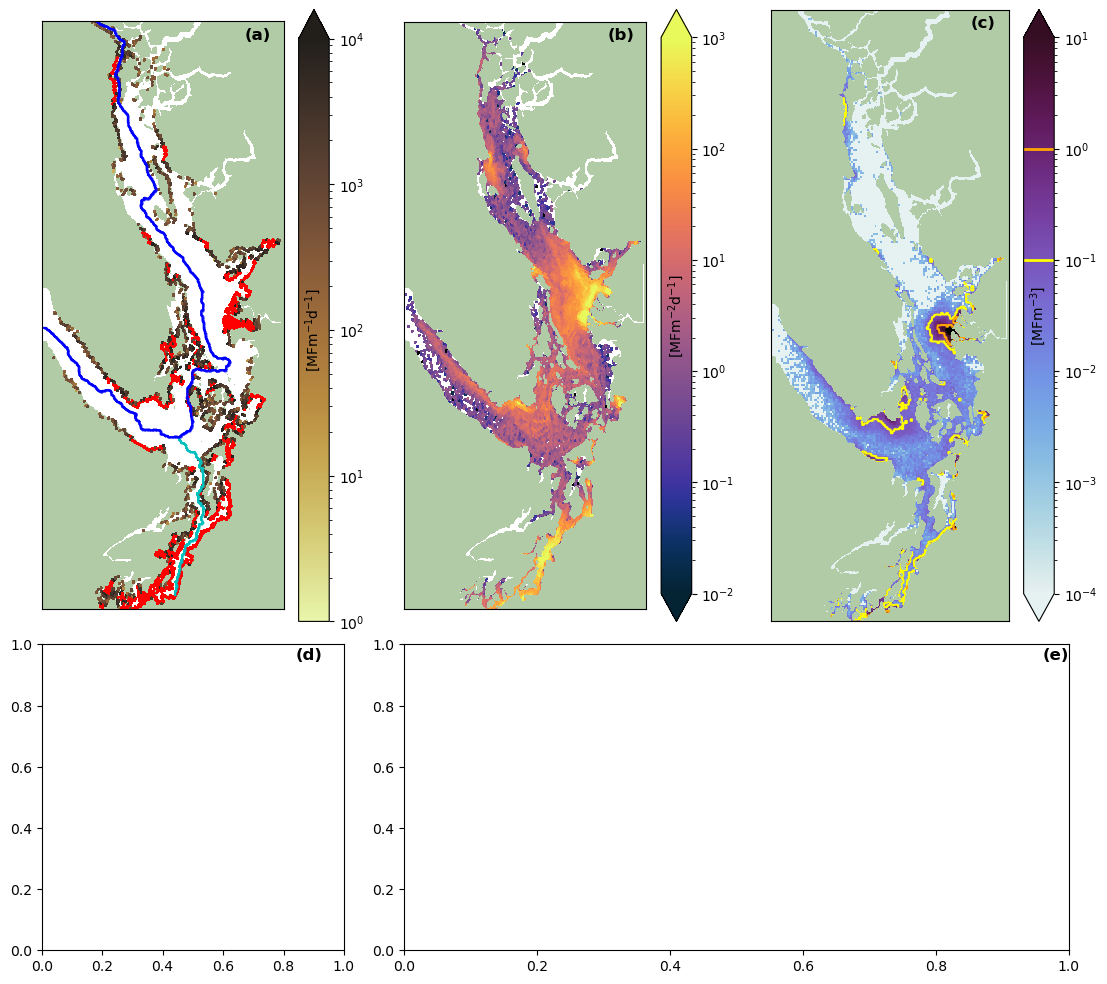

In [ ]:
letters = ['(a)', '(b)', '(c)', '(d)','(e)']

axes[0].text(0.84, 0.99, letters[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold', va='top')
axes[1].text(0.84, 0.99, letters[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold', va='top')
axes[2].text(0.84, 0.99, letters[2], transform=axes[2].transAxes, fontsize=12, fontweight='bold', va='top')
axes[3].text(0.84, 0.99, letters[3], transform=axes[3].transAxes, fontsize=12, fontweight='bold', va='top')
axes[4].text(0.96, 0.99, letters[4], transform=axes[4].transAxes, fontsize=12, fontweight='bold', va='top')


/tmp/ipykernel_2852499/3803162671.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmocean.cm.dense, len(levels) - 1)
/tmp/ipykernel_2852499/3803162671.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axes[4].pcolormesh(xx_thal, dep_thal, var_plot,cmap=cmocean.cm.dense,norm=colors.LogNorm(vmin=1e-4,vmax=10))#, cmap=cmap, norm=norm, shading='auto')
/tmp/ipykernel_2852499/3803162671.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which c

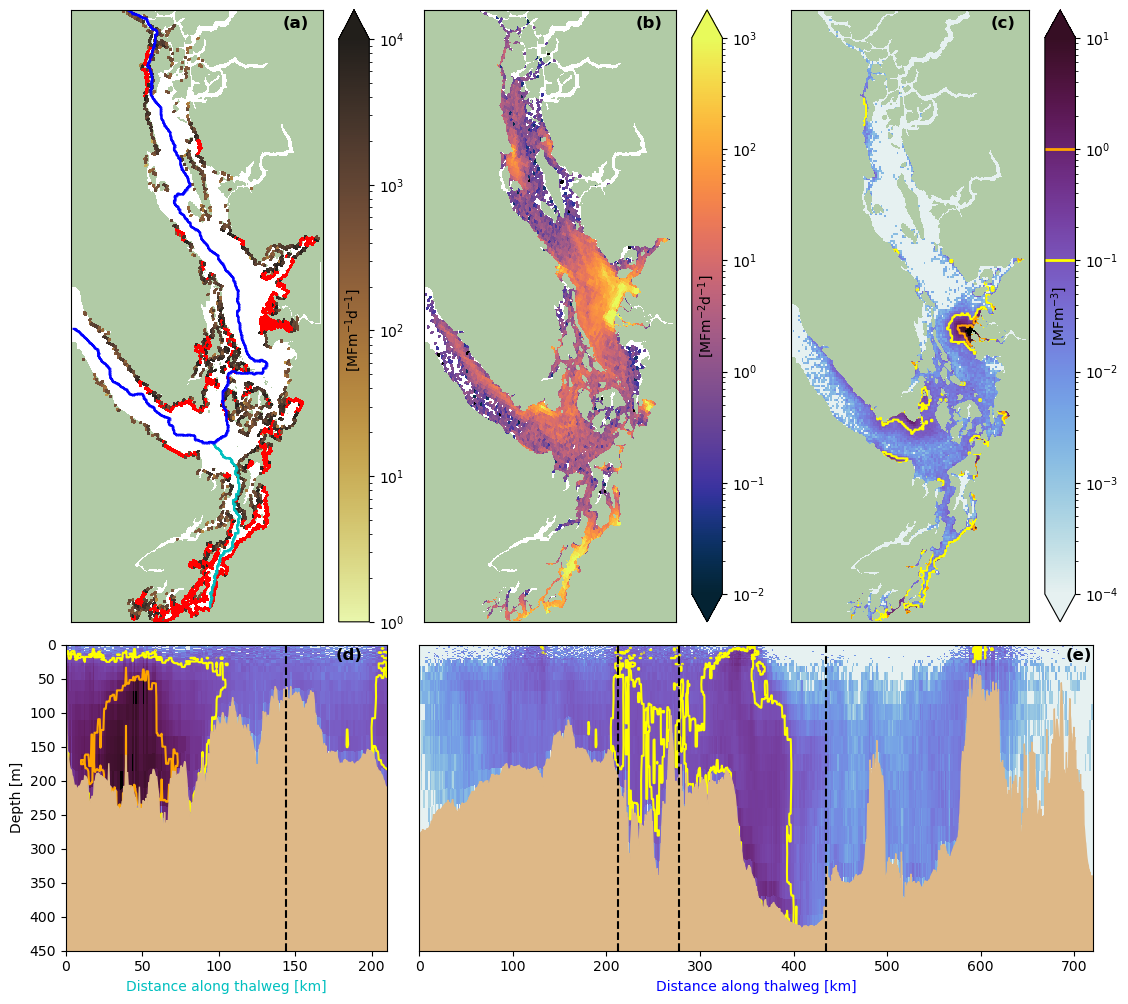

In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
from matplotlib.ticker import FuncFormatter

def log_tick_formatter(val, pos):
    return f"$10^{{{int(np.log10(val))}}}$"
# Define discrete levels for the colormap
clevels = [1e-4,1e-3,1e-2,1e-1,1,5,10]  # Log-spaced levels for colors

# Create a BoundaryNorm to map data to discrete colors
norm = BoundaryNorm(clevels, ncolors=256)

# Create a colormap (optional: use a predefined colormap or create your own)
cmap = get_cmap(cmocean.cm.dense, len(levels) - 1) 


dep_thal, distance, var_thal = vis.load_thalweg(depth[0, ...], var, fbathy['nav_lon'][:], fbathy['nav_lat'][:],thalweg_pts)
xx_thal = distance
axes[4].set_xlabel('Distance along thalweg [km]',color='b')
var_plot = vis._fill_in_bathy(var_thal, fmesh, thalweg_pts)
im = axes[4].pcolormesh(xx_thal, dep_thal, var_plot,cmap=cmocean.cm.dense,norm=colors.LogNorm(vmin=1e-4,vmax=10))#, cmap=cmap, norm=norm, shading='auto')
axes[4].contour(xx_thal, dep_thal, var_plot, levels=[0.1,2],colors=['yellow', 'orange'],zorder=1)

vis._add_bathy_patch(xx_thal, fbathy['Bathymetry'][:], thalweg_pts, axes[4], color='burlywood')
#axes[4].tick_params(left = False, right = False , labelleft = False) 

dep_thal, distance, var_thal = vis.load_thalweg(depth[0, ...], var, fbathy['nav_lon'][:], fbathy['nav_lat'][:],thalweg_pts2)
xx_thal = distance

axes[4].tick_params(axis='y', which='both', left=False, right=False, labelright=False,labelleft=False)
# axes[3].xaxis.set_label_position('top')
axes[3].set_xlabel('Distance along thalweg [km]',color='c')
var_plot = vis._fill_in_bathy(var_thal, fmesh, thalweg_pts2)
im = axes[3].pcolormesh(xx_thal, dep_thal, var_plot, cmap=cmocean.cm.dense,norm=colors.LogNorm(vmin=1e-4,vmax=10))
axes[3].contour(xx_thal, dep_thal, var_plot, levels=[0.1,2],colors=['yellow', 'orange'],zorder=1)

vis._add_bathy_patch(xx_thal, fbathy['Bathymetry'][:], thalweg_pts2, axes[3], color='burlywood')

fig.subplots_adjust(wspace=0.1, hspace=0.05)
axes[4].set_ylim([450,0])
axes[4].axvline(x=212,c='k',linestyle='--')
axes[4].axvline(x=277.5,c='k',linestyle='--')
axes[4].axvline(x=434.5,c='k',linestyle='--')
axes[3].axvline(x=144,c='k',linestyle='--')

axes[3].set_ylabel('Depth [m]')
#axes[4].set_ylabel('Depth [m]')


#axes[4].scatter(185,445,c='red',marker='^')
#axes[3].scatter(180,445,c='blue',marker='^')
#axes[4].axvline(x=185,c='k')
axes[3].set_ylim([450,0])
#axes[3].axvline(x=180,c='k')
axes[3].set_xlim([0,210])

In [25]:
Xline = np.linspace(-124.5,-122,100)
yline0 = (7/3)*Xline+334.6
yline1 = (20/33)*Xline+124.597
yline2 = np.zeros_like(Xline)+48.43
yline3 = np.zeros_like(Xline)+48.774

x0,y0 = np.zeros_like(Xline),np.zeros_like(Xline)
x1,y1 = np.zeros_like(Xline),np.zeros_like(Xline)
x2,y2 = np.zeros_like(Xline),np.zeros_like(Xline)
x3,y3 = np.zeros_like(Xline),np.zeros_like(Xline)
for i,Xi in enumerate(Xline):
    latj,loni = finder2(yline0[i],Xi)
    x0[i]=loni
    y0[i]=latj
    latj,loni = finder2(yline1[i],Xi)
    x1[i]=loni
    y1[i]=latj
    latj,loni = finder2(yline2[i],Xi)
    x2[i]=loni
    y2[i]=latj
    latj,loni = finder2(yline3[i],Xi)
    x3[i]=loni
    y3[i]=latj

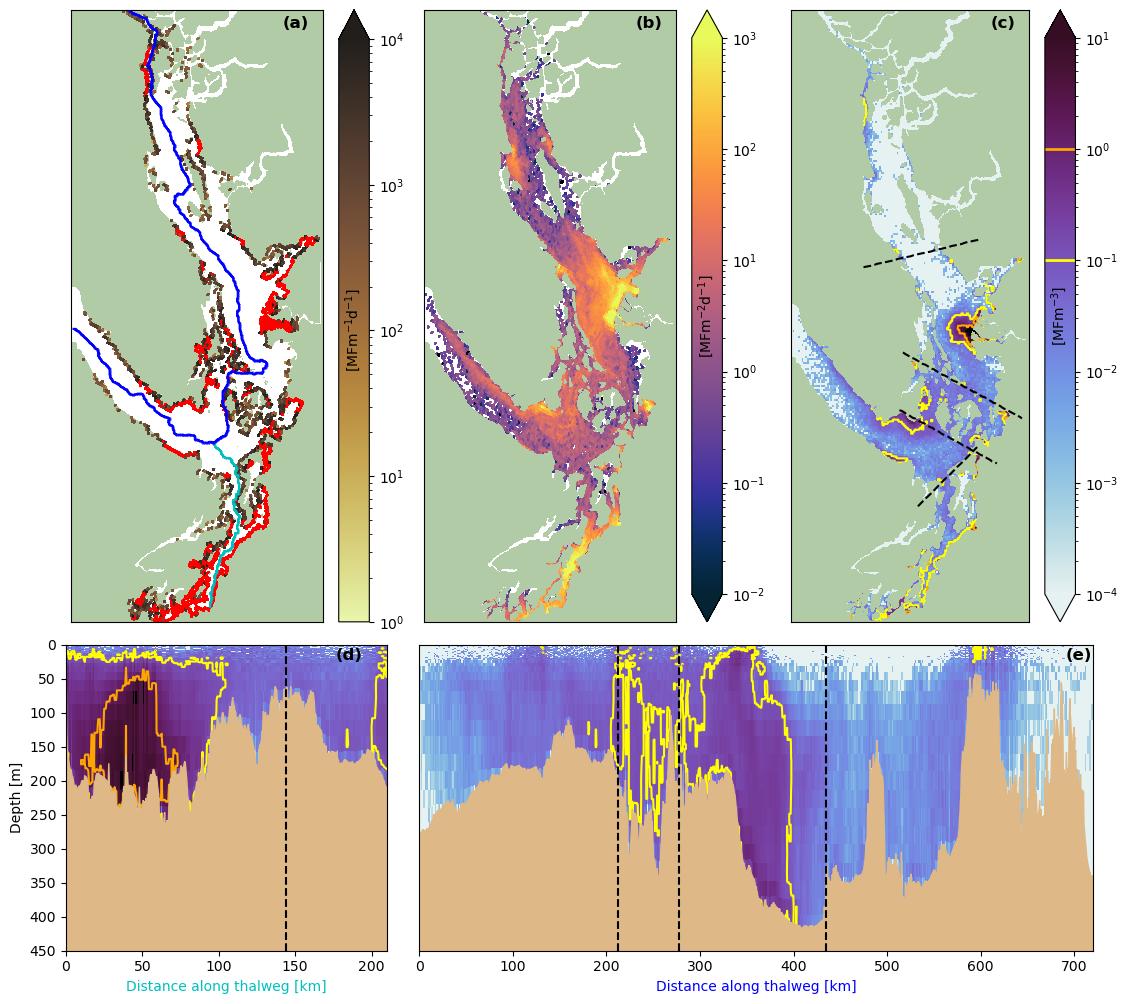

In [ ]:
axes[2].plot(x0[65:75],y0[65:75],'k--')
axes[2].plot(x1[:35],y1[:35],'k--')
axes[2].plot(x2[40:85],y2[40:85],'k--')
axes[2].plot(x3[30:85],y3[30:85],'k--')

In [27]:
box = axes[2].get_position()
axes[2].set_position([box.x0-0.01, box.y0, box.width, box.height]) 

box = axes[3].get_position()
axes[3].set_position([box.x0+0.05, box.y0, box.width*0.66, box.height])  # 


cbar = plt.colorbar(im, ax=axes[4],pad=0.05,aspect=10,shrink=1,extend='both')#,format=FuncFormatter(log_tick_formatter),ticks=[1e-4,1e-3,1e-2,1e-1,1,10])
cbar.set_label(r"[MFm$^{-3}$]", fontsize=10)
levels = [1e-1,1]
for level, color in zip(levels, ['yellow', 'orange']):
    cbar.ax.axhline(y=level, color=color, linewidth=2)

box = cbar.ax.get_position()
cbar.ax.set_position([box.x0+0.05, box.y0, box.width, box.height])  # 
cbar.ax.yaxis.set_label_coords(0.15, 0.45)
box = axes[4].get_position()
axes[4].set_position([box.x0-0.12+0.05, box.y0, box.width*1.25, box.height])
# fig

/tmp/ipykernel_2852499/610879143.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1100x1000 with 9 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, ax=axes[4],pad=0.05,aspect=10,shrink=1,extend='both')#,format=FuncFormatter(log_tick_formatter),ticks=[1e-4,1e-3,1e-2,1e-1,1,10])


<Figure size 640x480 with 0 Axes>

In [28]:
axes[0].set_title('Beaching')
axes[1].set_title('Sedimentation')
axes[2].set_title('Surface concentration')


Text(0.5, 1.0, 'Surface concentration')

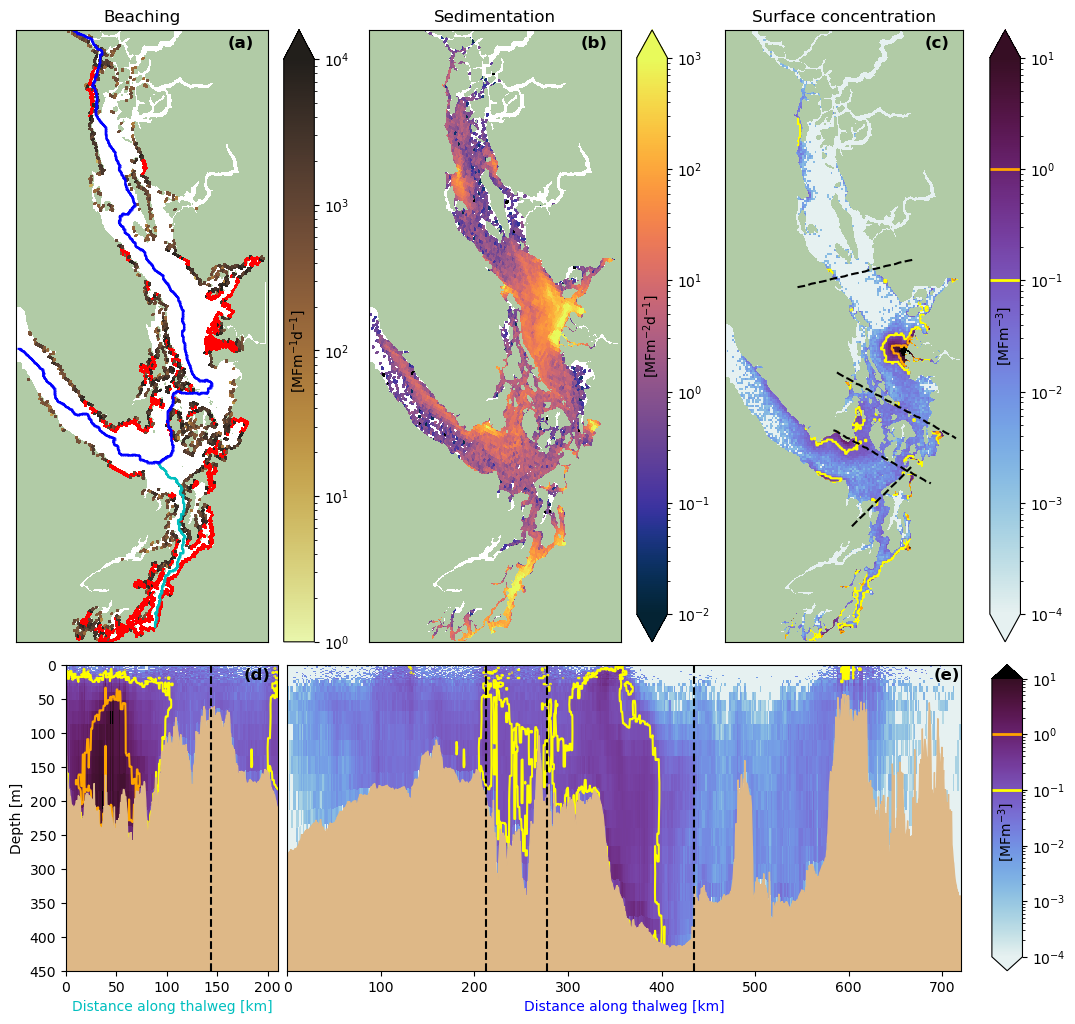

In [29]:
fig

In [ ]:
fig.savefig('thalweg_new3.pdf', bbox_inches='tight')